In [2]:
import deepquantum as dq
import torch

In [ ]:
## partial measurement

In [466]:
nmode = 2
circ = dq.QumodeCircuit(nmode=nmode, init_state='vac', cutoff=3, backend='gaussian', basis=True)
circ.s([0], r=11)
st = circ()
circ.draw()


In [467]:
re = circ.measure_homodyne(wires=[0], shots=1)
re 

ValueError: Expected parameter covariance_matrix (Tensor of shape (1, 2, 2)) of distribution MultivariateNormal(loc: torch.Size([1, 2]), covariance_matrix: torch.Size([1, 2, 2])) to satisfy the constraint PositiveDefinite(), but found invalid values:
tensor([[[0.0000e+00, 0.0000e+00],
         [0.0000e+00, 3.5849e+09]]])

# single loop case

In [411]:
def single_loop(r, samples):
    r = r
    samples = samples
    alpha = [np.pi / 4, 0]
    phi = [0, np.pi / 2]
    cov = torch.eye(4)
    mean  = torch.tensor([[[0.],[0.],[0.],[0.]]])
    cov = cov.unsqueeze(0)
    w = [0,1]
    measure_re = [ ]
    for i in range(samples):
        nmode = 2
        circ = dq.QumodeCircuit(nmode=nmode, init_state=[cov, mean], cutoff=3, backend='gaussian', basis=True)
        circ.s([w[1]], r=r)
        circ.bs([0,1], inputs=[alpha[w[0]], 0])
        circ.r(w[1], inputs=phi[w[0]])
        circ.to(torch.double)

        state = circ() # xxpp
        re = circ.measure_homodyne(wires=[w[0]], shots=1)
        qua_x = re[0] # x 
    #     print(circ.init_state.cov, circ.init_state.mean, '--------')
        measure_re.append(qua_x)

        sigma = dq.photonic.xxpp_to_xpxp(state[0])
        mu = state[1]
    #     mu = dq.photonic.xxpp_to_xpxp(state[1])
        sigma =sigma.squeeze()
        mu = mu.squeeze()
        mu_x = mu[:2]
        mu_p = mu[2:]

        block_list1 = [sigma[:2, :2], sigma[2:, 2:]]
        block_list2 = [sigma[2:, :2], sigma[:2, 2:]]
        sigma_a = block_list1[w[1]]
        sigma_b = block_list1[w[0]]
        sigma_ab = block_list2[w[0]]

        sigma_a2 = sigma_a - sigma_ab @ torch.linalg.inv(sigma_b + cov_ob) @ sigma_ab.mT
        mu_2 = torch.tensor([mu_x[w[1]], mu_p[w[1]]]) + sigma_ab @ torch.linalg.inv(sigma_b + cov_ob) @ (re - torch.tensor([mu_x[w[0]], mu_p[w[0]]]))


        cov = torch.eye(4)
        if w[0] == 0:
            cov[2:,2:] = sigma_a2
            mean = torch.cat([torch.zeros(2), mu_2])


        if w[1] == 0:
            cov[:2, :2] = sigma_a2
            mean = torch.cat([mu_2, torch.zeros(2)])

        cov = cov.unsqueeze(0)
        mean = mean.unsqueeze(0).mT
        cov = dq.photonic.xpxp_to_xxpp(cov)
        mean = dq.photonic.xpxp_to_xxpp(mean)
        w = shift(w)
    return measure_re


In [397]:
# alpha = [np.pi / 4, np.pi / 4]
# phi = [0, 0]
r=5
alpha = [np.pi / 4, 0]
phi = [0, np.pi / 2]
cov = torch.eye(4)
mean  = torch.tensor([[[0.],[0.],[0.],[0.]]])
cov = cov.unsqueeze(0)
samples = 2000
w = [0,1]
measure_re = [ ]
for i in range(samples):
    nmode = 2
    circ = dq.QumodeCircuit(nmode=nmode, init_state=[cov, mean], cutoff=3, backend='gaussian', basis=True)
    circ.s([w[1]], r=r)
    circ.bs([0,1], inputs=[alpha[w[0]], 0])
    circ.r(w[1], inputs=phi[w[0]])
    circ.to(torch.double)
    
    state = circ() # xxpp
    re = circ.measure_homodyne(wires=[w[0]], shots=1)
    qua_x = re[0]
#     print(circ.init_state.cov, circ.init_state.mean, '--------')
    measure_re.append(qua_x)
    
    sigma = dq.photonic.xxpp_to_xpxp(state[0])
#     mu = dq.photonic.xxpp_to_xpxp(state[1])
    sigma =sigma.squeeze()
    mu = mu.squeeze()
    mu_x = mu[:2]
    mu_p = mu[2:]
    
    block_list1 = [sigma[:2, :2], sigma[2:, 2:]]
    block_list2 = [sigma[2:, :2], sigma[:2, 2:]]
    sigma_a = block_list1[w[1]]
    sigma_b = block_list1[w[0]]
    sigma_ab = block_list2[w[0]]
    
    sigma_a2 = sigma_a - sigma_ab @ torch.linalg.inv(sigma_b + cov_ob) @ sigma_ab.mT
    mu_2 = torch.tensor([mu_x[w[1]], mu_p[w[1]]]) + sigma_ab @ torch.linalg.inv(sigma_b + cov_ob) @ (re - torch.tensor([mu_x[w[0]], mu_p[w[0]]]))
    
    
    cov = torch.eye(4)
    if w[0] == 0:
        cov[2:,2:] = sigma_a2
        mean = torch.cat([torch.zeros(2), mu_2])
    
    
    if w[1] == 0:
        cov[:2, :2] = sigma_a2
        mean = torch.cat([mu_2, torch.zeros(2)])
    
    cov = cov.unsqueeze(0)
    mean = mean.unsqueeze(0).mT
    cov = dq.photonic.xpxp_to_xxpp(cov)
    mean = dq.photonic.xpxp_to_xxpp(mean)
#     print(mean)
        
    w = shift(w)

In [398]:
circ.draw()

In [425]:
Mean = [ ]
Std = [ ]
for r in np.linspace(0.1, 7, 70):
    shots = 2000
    re = single_loop(r=r, samples=samples)
    re_up = torch.stack(re[::2]) # first of  EPR
    re_down = torch.stack(re[1::2]) # second of EPR
    Mean.append(re_up.mean()-re_down.mean())
    Std.append((re_up-re_down).std())
    print(r, end="\r")

## check result

In [426]:
import matplotlib.pyplot as plt  

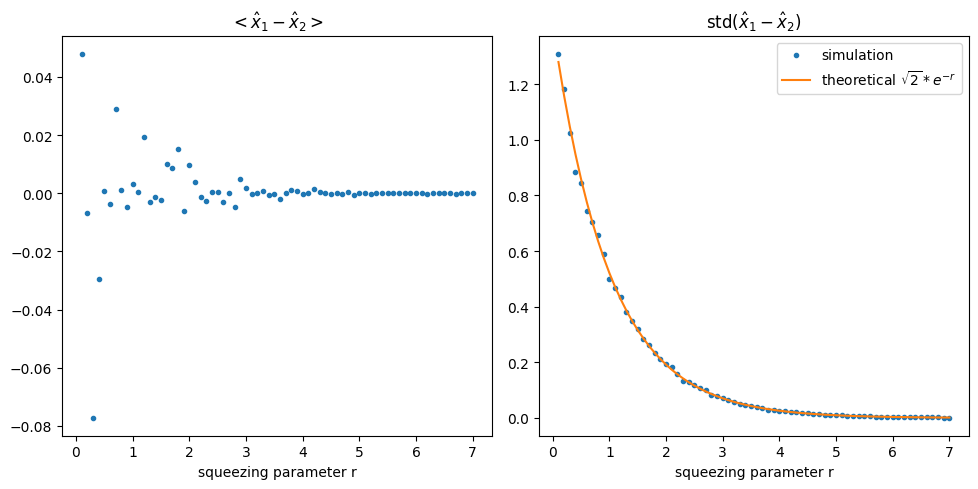

<Figure size 640x480 with 0 Axes>

In [443]:
fig, axs = plt.subplots(1, 2, figsize=(5*2, 5))
ax1 = plt.subplot(1,2,1)
r_list = np.linspace(0.1, 7, 70)

plt.plot(np.linspace(0.1, 7, 70),Mean,".")
plt.title("$<\hat{x}_1-\hat{x}_2>$")

plt.xlabel("squeezing parameter r")

plt.tight_layout()

ax2 = plt.subplot(1,2,2)
plt.plot(r_list, np.array(Std),".",label = "simulation")
plt.plot(r_list, np.exp(-1*r_list)*np.sqrt(2), label = "theoretical $\sqrt{2}*e^{-r}$")
plt.title("std($\hat{x}_1-\hat{x}_2$)")
plt.xlabel("squeezing parameter r")
plt.legend()
# plt.plot(np.linspace(0.1, 10, 100), Std,".")
plt.show()
plt.tight_layout()


In [444]:
circ.draw()

In [10]:
def shift(a):
    if len(a) <=1:
        return a
    return a[-1:] + a[:-1]

# add measure_dyne

In [3]:
import strawberryfields as sf 
import deepquantum as dq
import torch

In [2]:
cov = torch.stack([torch.eye(6)]*3)
mean = torch.stack([torch.zeros(6)]*3)
# cov, mean

In [15]:
###############
nmode = 3
circ = dq.QumodeCircuit(nmode=nmode, init_state=[cov, mean], cutoff=3, backend='gaussian', basis=True)
circ.s([0], r=1)
circ.d([1], r=1, theta=np.pi/4)
circ.s([1], r=2)
circ.bs([0,1])
circ.bs([1,2])
circ.to(torch.double)
st = circ()
circ.draw()

In [16]:
st

[tensor([[[ 2.1186e+00,  1.2218e-02, -8.1885e+00,  4.6041e+00, -2.4828e+00,
            3.3017e+00],
          [ 1.2218e-02,  9.4961e-01, -7.9768e-02, -3.3601e-01, -4.4841e-02,
            2.2622e-01],
          [-8.1885e+00, -7.9768e-02,  3.5026e+01, -1.5772e+01,  1.0305e+01,
           -1.3608e+01],
          [ 4.6041e+00, -3.3601e-01, -1.5772e+01,  1.6239e+01, -4.9292e+00,
            7.7408e+00],
          [-2.4828e+00, -4.4841e-02,  1.0305e+01, -4.9292e+00,  4.1124e+00,
           -4.0418e+00],
          [ 3.3017e+00,  2.2622e-01, -1.3608e+01,  7.7408e+00, -4.0418e+00,
            5.6958e+00]],
 
         [[ 2.1186e+00,  1.2218e-02, -8.1885e+00,  4.6041e+00, -2.4828e+00,
            3.3017e+00],
          [ 1.2218e-02,  9.4961e-01, -7.9768e-02, -3.3601e-01, -4.4841e-02,
            2.2622e-01],
          [-8.1885e+00, -7.9768e-02,  3.5026e+01, -1.5772e+01,  1.0305e+01,
           -1.3608e+01],
          [ 4.6041e+00, -3.3601e-01, -1.5772e+01,  1.6239e+01, -4.9292e+00,
            

In [17]:
re = circ.measure_homodyne(shots=50000, wires=[0,1])
re.mean(dim=1)

tensor([[-2.0965,  0.0468, -4.5587,  2.4867],
        [-2.0856,  0.0468, -4.5550,  2.4750],
        [-2.0924,  0.0424, -4.5675,  2.4779]], dtype=torch.float64)

In [19]:
circ.state

[tensor([[[ 1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  3.3756,  0.0000,  0.0000, -0.8398],
          [ 0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000],
          [ 0.0000,  0.0000, -0.8398,  0.0000,  0.0000,  0.5052]],
 
         [[ 1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  3.3756,  0.0000,  0.0000, -0.8398],
          [ 0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000],
          [ 0.0000,  0.0000, -0.8398,  0.0000,  0.0000,  0.5052]],
 
         [[ 1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  3.3756,  0.0000,  0.0000, -0.8398],
    

In [641]:
sf.backends.gaussianbackend.ops.chop_in_blocks((cov.detach().numpy()), expind)

(array([[  4.0971174,   5.5510406,   3.4711766,  -7.966277 ],
        [  5.5510406,  13.535728 ,   3.080985 , -10.093341 ],
        [  3.4711766,   3.080985 ,   4.077392 ,  -7.231399 ],
        [ -7.966277 , -10.093341 ,  -7.231399 ,  16.785578 ]], dtype=float32),
 array([[  0.02910483,  -9.728976  ],
        [ -1.3166736 , -11.741719  ],
        [ -0.0491935 ,  -8.798813  ],
        [ -0.42055374,  19.435282  ]], dtype=float32),
 array([[ 0.76264727, -0.41036683],
        [-0.41036683, 24.88239288]]))

In [84]:
##############
def exchange_row_cols(cov, mea_idices):
    """
    reorder the cov matrix, support vmap
    """
    row_list =[ ]
    col_list = [ ]
    idx_min= mea_idices[0]
    idx_max = mea_idices[-1]
    if idx_max == cov.size()[-1]:
        return cov
    else:
        exchange_list = list(range(0, idx_min, 2)) + list(range(idx_max+1, cov.size()[-1],2)) + \
                         list(range(idx_min, idx_max, 2))
        for i in exchange_list:
            row_list.append(cov[[i, i+1]])
        cov1 = torch.cat(row_list)
        for i in exchange_list:
            col_list.append(cov1[:, [i,i+1]])
        cov2 = torch.cat(col_list, dim=1)
        return cov2

# test measuredyne

In [133]:
def permute_mat(i, j, size):
    """
    return the permute matrix for exchanging i-th row with j -th row of matrix a 
    """
    p_row = torch.eye(size, dtype=torch.float)
    p_row[[i, j]] = p_row[[j, i]]
    return p_row

In [138]:
def exchange_row_cols2(cov, measure_indices, reverse=False):
    n = cov.size()[-1]
    len_ = len(measure_indices)
    j_indices = range(n - len_, n+1)
    exchange_mat = torch.eye(n, dtype=cov.dtype)
    for k in range(len(measure_indices)-1, -1, -1):
        i = measure_indices[k]
        j = j_indices[k]
        p_mat = permute_mat(i, j, n)
        exchange_mat =p_mat @ exchange_mat
    if reverse:
        exchange_mat = torch.linalg.inv(exchange_mat)
    return exchange_mat @ cov @ exchange_mat.mT

In [2]:
test = torch.arange(0, 36).reshape(6, 6)
test=test.to(torch.float)
exchange_row_cols(test, [0,1,2,3])

NameError: name 'exchange_row_cols' is not defined

In [4]:
import strawberryfields as sf
from strawberryfields.ops import Sgate, BSgate, Rgate, MeasureHomodyne, Dgate

In [5]:
np.set_printoptions( linewidth=1000)

In [16]:
n = 3
np.random.seed(42)

r1 = np.random.rand(1)
r2 = np.random.rand(1)
r3 = np.random.rand(1)
bs1 = np.random.rand(2)
bs2 = np.random.rand(2)
meas_angle = np.random.rand(1)

prog0 = sf.Program(n)
with prog0.context as q:
#     for i in range(n - 1):
    Sgate(r1) | q[0]
    Dgate(r2) | q[1]
    Sgate(r3) | q[1]
    BSgate(*bs1) | (q[0], q[1])
    BSgate(*bs2) | (q[1], q[2])

    MeasureHomodyne(meas_angle[0]) | q[0]
#     MeasureHomodyne(meas_angle[1]) | q[1]
eng0 = sf.Engine("gaussian")
result0 = eng0.run(prog0)
result0.state.cov(), result0.state.means() #xxpp

(array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.33649593, -0.10332561,  0.        , -0.09301699, -0.02066199],
        [ 0.        , -0.10332561,  0.98408558,  0.        , -0.03378242, -0.00624742],
        [ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ,  0.        ],
        [ 0.        , -0.09301699, -0.03378242,  0.        ,  3.10060268,  0.32896026],
        [ 0.        , -0.02066199, -0.00624742,  0.        ,  0.32896026,  1.05146045]]),
 array([ 0.        ,  0.72910571,  0.11915392,  0.        , -0.51251546, -0.07381196]))

In [17]:
result0.samples[0]

array([0.81493195])

In [18]:
###############
nmode = 3
circ = dq.QumodeCircuit(nmode=nmode, init_state='vac', cutoff=3, backend='gaussian', basis=True)
circ.s([0], r=r1)
circ.d([1], r=r2)
circ.s([1], r=r3)
circ.bs([0,1], inputs=bs1)
circ.bs([1,2], inputs=bs2)
circ.to(torch.double)
st = circ()
circ.draw()

In [19]:
st 

[tensor([[[ 0.4275,  0.1097,  0.0197,  0.1995, -0.2751, -0.0422],
          [ 0.1097,  0.3370, -0.1034, -0.1346, -0.0781, -0.0183],
          [ 0.0197, -0.1034,  0.9841, -0.0120, -0.0355, -0.0065],
          [ 0.1995, -0.1346, -0.0120,  2.7849, -1.0031, -0.1587],
          [-0.2751, -0.0781, -0.0355, -1.0031,  3.5464,  0.3991],
          [-0.0422, -0.0183, -0.0065, -0.1587,  0.3991,  1.0625]]],
        dtype=torch.float64),
 tensor([[[-0.5091],
          [ 0.7463],
          [ 0.1172],
          [ 0.0801],
          [ 0.0000],
          [ 0.0068]]], dtype=torch.float64)]

In [20]:
torch.manual_seed(42)
re = circ.measure_homodyne(wires=[0], shots=100000, thetas=meas_angle[0])
circ.state

[tensor([[[ 1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.3365, -0.1033,  0.0000, -0.0930, -0.0207],
          [ 0.0000, -0.1033,  0.9841,  0.0000, -0.0338, -0.0062],
          [ 0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
          [ 0.0000, -0.0930, -0.0338,  0.0000,  3.1006,  0.3290],
          [ 0.0000, -0.0207, -0.0062,  0.0000,  0.3290,  1.0515]]],
        dtype=torch.float64),
 tensor([[[ 0.0000e+00],
          [ 7.4627e-01],
          [ 1.1717e-01],
          [ 0.0000e+00],
          [-3.0042e-04],
          [ 6.7661e-03]]], dtype=torch.float64)]

In [21]:
circ.draw()

In [22]:
abs(circ.state[0][0] - result0.state.cov()).max()

tensor(1.2514e-07, dtype=torch.float64)